# Representation Learning using Auto Encoders

In [2]:
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split

2024-05-11 20:10:31.557029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 20:10:31.557126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 20:10:31.674836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.2.1
TensorFlow version: 2.15.0


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [5]:
data = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
(X_train, y_train), (X_test, y_test) = data
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
plt.imshow(X_train[0], cmap='gray')
plt.title("Sample Image from MNIST")
plt.axis('off')
plt.show()

In [ ]:
noised_image = X_train[0] + np.random.normal(0, 0.1, X_train[0].shape)

plt.imshow(noised_image, cmap='gray')
plt.title("Noised Sample Image from MNIST")
plt.axis('off')
plt.show()

In [8]:
def noising_process(input, stddev=0.1):
    noised_input = input + np.random.normal(0, stddev, input.shape)

    return np.clip(noised_input, 0.0, 1.0)

def print_imgs(real, reconstructed):
    num_images = 10
    indices = np.random.choice(len(real), size=num_images, replace=False)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

    axes[0, 0].set_title('Original Images', fontsize=12)
    axes[1, 0].set_title('Reconstructed Images', fontsize=12)

    for idx, index in enumerate(indices):
        ax1 = axes[0, idx]
        ax1.imshow(real[index].reshape(28, 28), cmap='gray')
        ax1.axis('off')

        ax2 = axes[1, idx]
        ax2.imshow(reconstructed[index].reshape(28, 28), cmap='gray')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Let's first see if the model is good enough to learn the identity function:

In [9]:
model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/20
 70/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900

I0000 00:00:1715449734.472882      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715449734.487543      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0396

W0000 00:00:1715449736.214205      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715449736.776347      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0395 - val_loss: 0.0074
Epoch 2/20
 79/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073

W0000 00:00:1715449737.186717      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 9.6644e-04
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4755e-04 - val_loss: 9.0442e-04
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


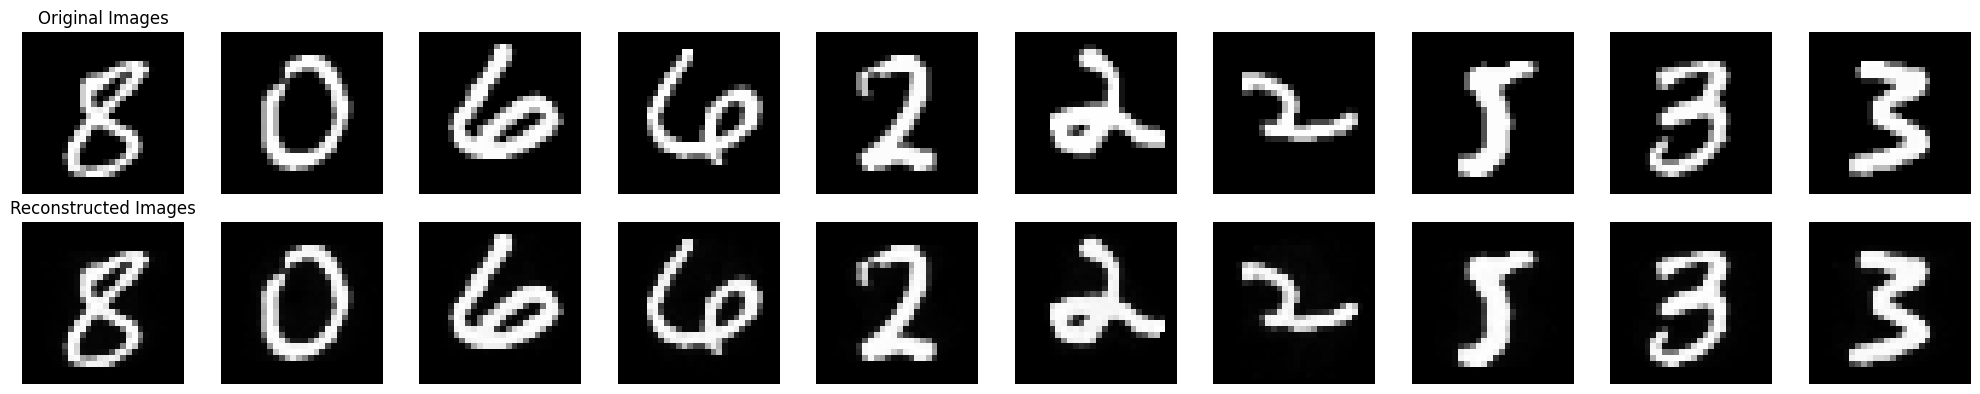

In [10]:
predictions = model.predict(X_test)
print_imgs(X_test, predictions)

Now let's see if it learns the distributiono using the noised version of the input (we'll start by a small gaussian noise, i.e. one with stddev=0.1):

In [11]:
model.fit(
    noising_process(X_train, 0.1),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.1), X_test),
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


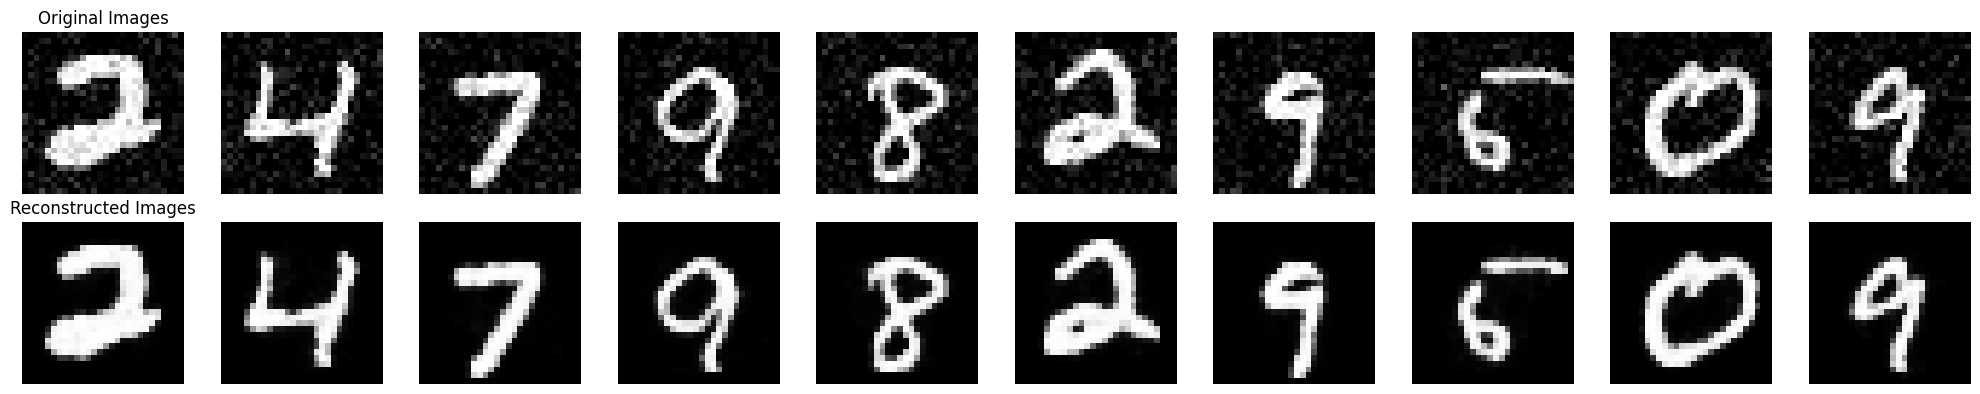

In [12]:
noised_data = noising_process(X_test, 0.1)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


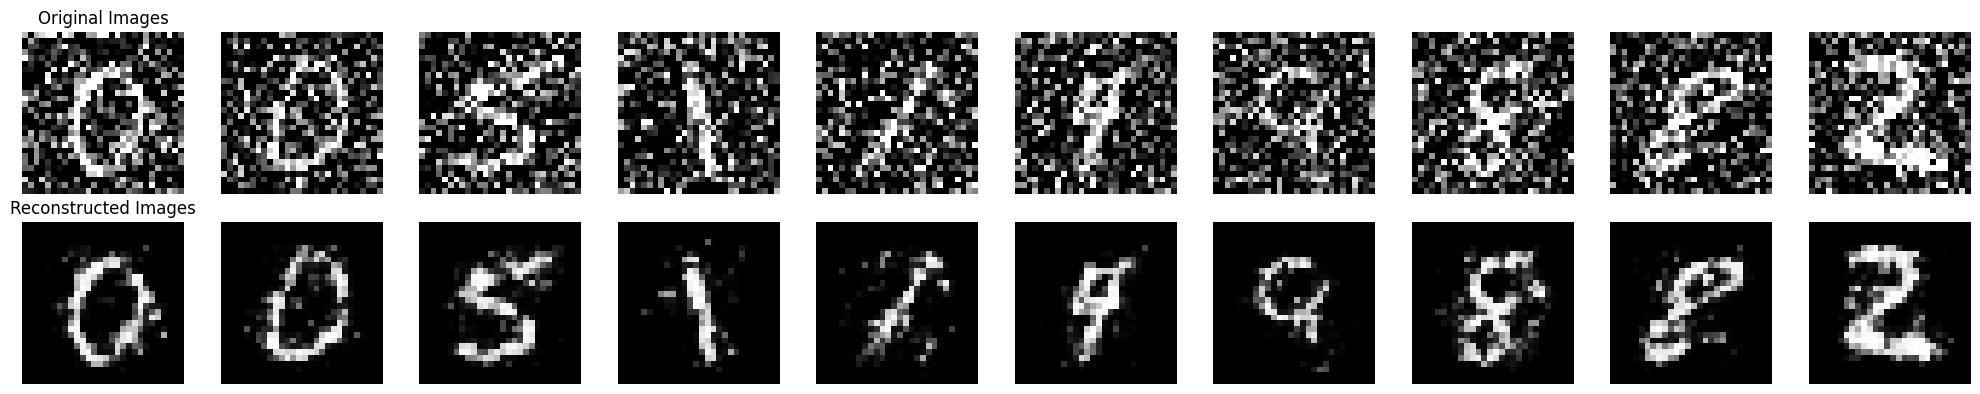

In [13]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

Since the model struggles a bit to reconstruct images with stronger noise, we will retrain it using more disturbed images

In [18]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 69/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0936

W0000 00:00:1715450019.695849      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513

W0000 00:00:1715450021.145776      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715450021.571911      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0513 - val_loss: 0.0195
Epoch 2/10
 76/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195

W0000 00:00:1715450021.817456      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - val_loss: 0.0154
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0132
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118 - val_loss: 0.0129
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0128
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0126
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0126


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


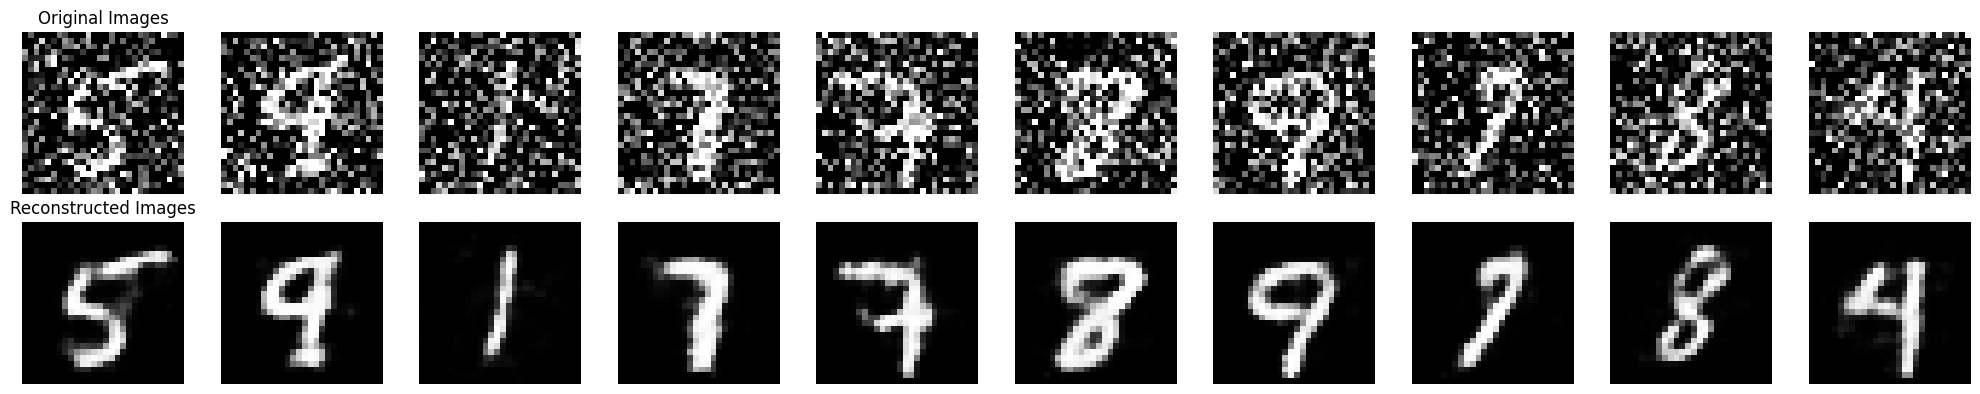

In [20]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

and as we can see, the model actually does a better job at reconstructing strong-noised images (in this case gaussian noise with 0.5 stddev)

Now we will observe what happens if we follow the gradient of the probability function

First, we will look at what happens when starting from a real image to which we add some noise (following the gradient must result in a very precise result of the digit)

In [27]:
max_iter = 10000
epsilon = 1e-5
previous_loss = None

img = tf.cast(X_test[0], tf.float32)
noised_image = tf.Variable(initial_value=tf.reshape(noising_process(img, 0.5).astype(np.float32), shape=(1, 28, 28)), trainable=True)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = model(noised_image)
        loss = -tf.reduce_sum(tf.square(reconstruction - noised_image))     # to maximize similarity through MSE

    gradient = g.gradient(loss, noised_image)

    noised_image.assign_add(gradient * 0.01)

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter-1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break


    previous_loss = loss.numpy()


iteration: 0, loss: -89.02439880371094
iteration: 1000, loss: -0.5927276611328125
Converged at iteration 1645 w/ loss: -0.5045288801193237 and epsilon: -2.384185791015625e-06


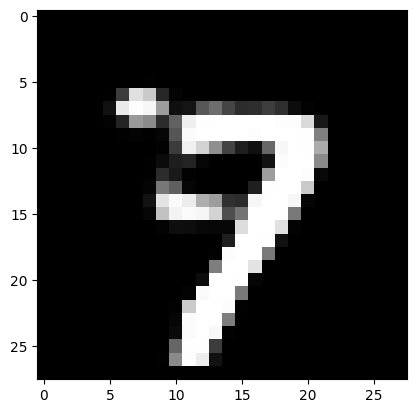

In [28]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

In [25]:
max_iter = 10000
epsilon = 1e-5
previous_loss = None

noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28)), trainable=True)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = model(noised_image)
        loss = -tf.reduce_sum(tf.square(reconstruction - noised_image))     # to maximize similarity through MSE

    gradient = g.gradient(loss, noised_image)

    noised_image.assign_add(gradient * 0.01)

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter-1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break


    previous_loss = loss.numpy()


iteration: 0, loss: -763.1936645507812
iteration: 1000, loss: -0.15290547907352448
iteration: 2000, loss: -0.12011992931365967
Converged at iteration 2604 w/ loss: -0.11179648339748383 and epsilon: -9.909272193908691e-06


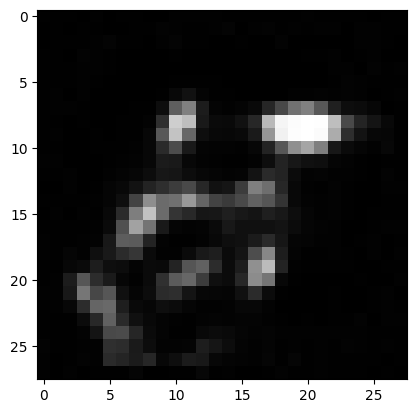

In [26]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

it seems like the reconstruction is converging to the data manifold, but the hidden representation might be not adequate.

## Unsupervised layerwise pretraining
In the following, we are going to see if performance increases when stacking auto-encoder, i.e. using a deep-AE.

To do so, we will train each auto-encoder separately, starting from the input data. The auto-encoders following the first one will take as input the previous encoder's representation. Thus at each training step the decoder will be discarded, up until the last layer.

In [21]:
def create_autoencoder(input_dim, encoding_dim):
    input_layer = K.Input(shape=(input_dim,))
    encoder_layer = K.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoder_layer = K.layers.Dense(input_dim, activation='sigmoid')
    decoder_output = decoder_layer(encoder_layer)
    
    autoencoder = K.Model(input_layer, decoder_output)
    encoder = K.Model(input_layer, encoder_layer)
    
    decoder_input = K.Input(shape=(encoding_dim,))
    decoder_output = decoder_layer(decoder_input)
    decoder = K.Model(decoder_input, decoder_output)
    
    autoencoder.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return autoencoder, encoder, decoder

def layerwise_pretraining(data, layers, noise_level=0.5, epochs=20):
    encoders = []
    decoders = []
    inputs = data
    
    for i, (input_dim, encoding_dim) in enumerate(zip(layers[:-1], layers[1:])):
        early_stopping = K.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            restore_best_weights=True)
        print(f"Training layer {i+1}/{len(layers)-1}")
        print(f'creating ae #{i} with input_dim:{input_dim}, encoding_dim:{encoding_dim}')

        noisy_inputs = noising_process(inputs, noise_level)
        
        autoencoder, encoder, decoder = create_autoencoder(input_dim, encoding_dim)
        autoencoder.summary()
        
        autoencoder.fit(
            noisy_inputs,
            inputs,
            epochs=epochs,
            batch_size=128,
            shuffle=True,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
    
        inputs = encoder(noisy_inputs)
        encoders.append(encoder)
        decoders.append(decoder)
        
    return encoders, decoders

In [22]:
X_train_reshaped = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_reshaped = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [23]:
layer_sizes = [784, 1024, 1024]
encoders, decoders = layerwise_pretraining(X_train_reshaped, layer_sizes, epochs=50)

stacked_ae = K.Sequential()
for encoder in encoders:
    stacked_ae.add(encoder.layers[1])
    
for decoder in decoders[::-1]:
    stacked_ae.add(decoder.layers[1])
    
stacked_ae.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
stacked_ae.summary()

Training layer 1/2
creating ae #0 with input_dim:784, encoding_dim:1024


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 70/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0916  

W0000 00:00:1715458735.025463      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


365/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0549

W0000 00:00:1715458736.121110      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0544 - val_loss: 0.0226
Epoch 2/50
 77/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217

W0000 00:00:1715458736.334742      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0168
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0136
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0135
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0132
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 13/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,200 (8.01 MB)

 Trainable params: 2,099,200 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2213 - val_loss: 0.1548
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1523 - val_loss: 0.1460
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1450 - val_loss: 0.1430
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1426 - val_loss: 0.1413
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1406 - val_loss: 0.1404
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1395 - val_loss: 0.1401
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1388 - val_loss: 0.1395
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1381 - val_loss: 0.1392
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1374 - val_loss: 0.1390
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1374 - val_loss: 0.1389
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1373 - val_loss: 0.1389
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,640 (14.14 MB)

 Trainable params: 3,706,640 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

125/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715458771.390945      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1715458771.888252      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


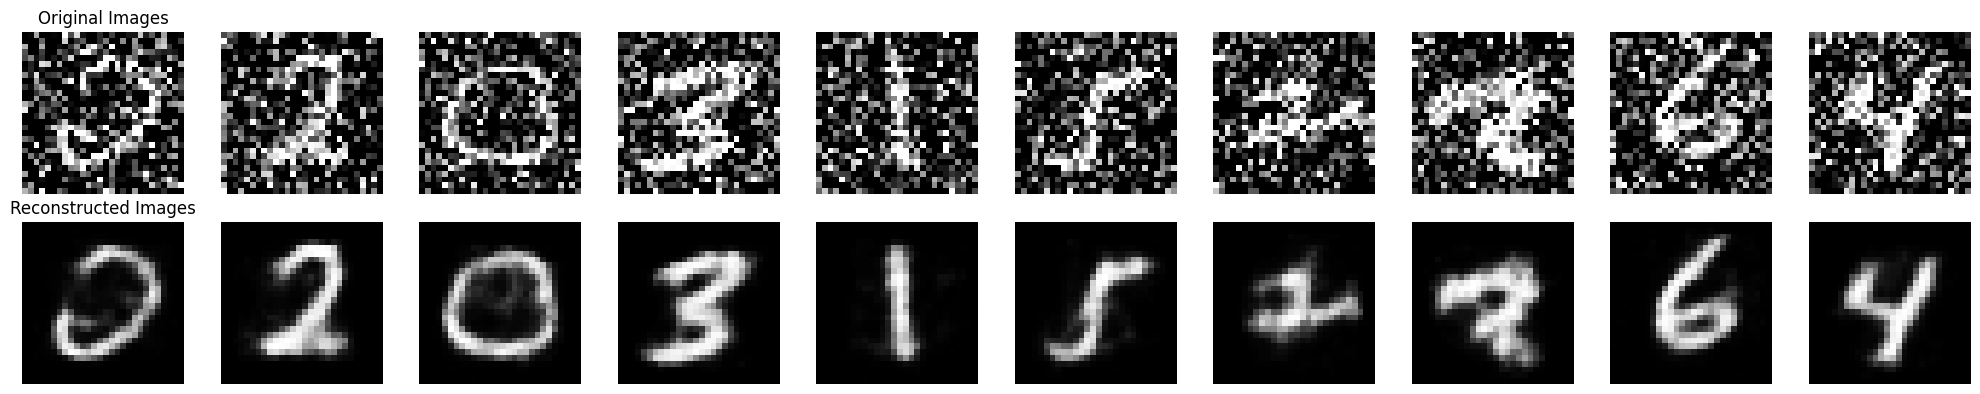

In [24]:
noised_data = noising_process(X_test_reshaped, 0.5)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [25]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

stacked_ae.fit(
    noising_process(X_train_reshaped, 0.5),
    X_train_reshaped,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
 43/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171

W0000 00:00:1715458776.727789      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


368/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151

W0000 00:00:1715458778.308882      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 2/50
 57/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125

W0000 00:00:1715458778.633400      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0133
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0133
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0130
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0130
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0130
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0130
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0131
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


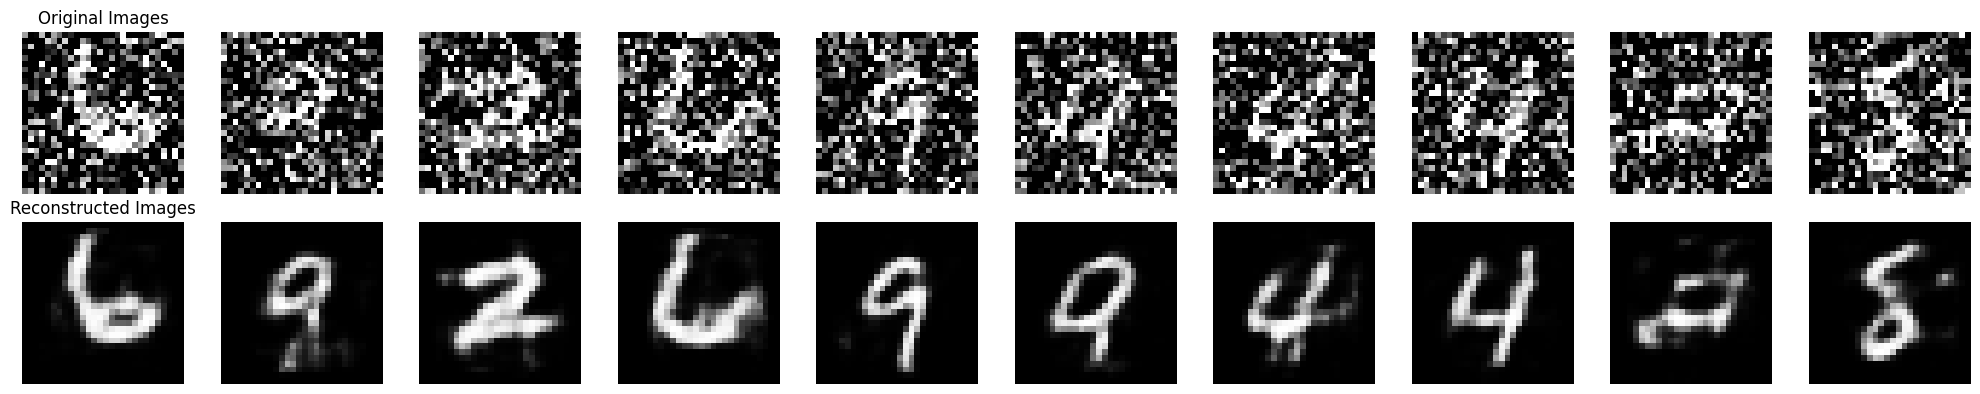

In [26]:
noised_data = noising_process(X_test_reshaped, 0.6)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [28]:
max_iter = 5000
epsilon = 1e-16
previous_loss = None

# Initialize the noised image as a trainable variable
noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, 784).astype(np.float32), (1, 784)), trainable=True)

# Initialize the Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = stacked_ae(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))  # to maximize similarity through MSE

    # Compute gradients and apply them through the optimizer
    gradients = g.gradient(loss, [noised_image])
    optimizer.apply_gradients(zip(gradients, [noised_image]))

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter - 1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = current_loss

iteration: 0, loss: 756.740478515625
iteration: 1000, loss: 0.11453944444656372
iteration: 2000, loss: 0.07318209856748581
Converged at iteration 2603 w/ loss: 0.06948662549257278 and epsilon: 0.0


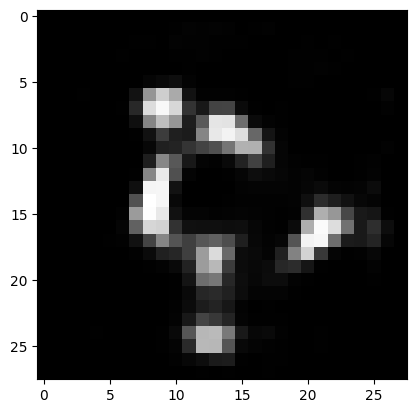

In [29]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

In [101]:
max_iter = 20000
epsilon = 1e-16
previous_loss = None

noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, 784).astype(np.float32), (1, 784)), trainable=True)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = stacked_ae(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))     # to maximize similarity through MSE

    gradient = -g.gradient(loss, noised_image)

    noised_image.assign_add(gradient * 0.01)

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter-1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = loss.numpy()


iteration: 0, loss: 748.5067749023438
iteration: 1000, loss: 0.13279113173484802
iteration: 2000, loss: 0.0524165965616703
iteration: 3000, loss: 0.03615444526076317
iteration: 4000, loss: 0.027896041050553322
iteration: 5000, loss: 0.022778252139687538
iteration: 6000, loss: 0.018990783020853996
iteration: 7000, loss: 0.015993686392903328
iteration: 8000, loss: 0.013788556680083275
iteration: 9000, loss: 0.012386176735162735
iteration: 10000, loss: 0.01105238776654005
iteration: 11000, loss: 0.009872044436633587
iteration: 12000, loss: 0.009054426103830338
iteration: 13000, loss: 0.008346599526703358
iteration: 14000, loss: 0.007944307290017605
iteration: 15000, loss: 0.007664297241717577
iteration: 16000, loss: 0.00738906767219305
iteration: 17000, loss: 0.007131771184504032
iteration: 18000, loss: 0.006903865374624729
Converged at iteration 18955 w/ loss: 0.006792244501411915 and epsilon: 0.0


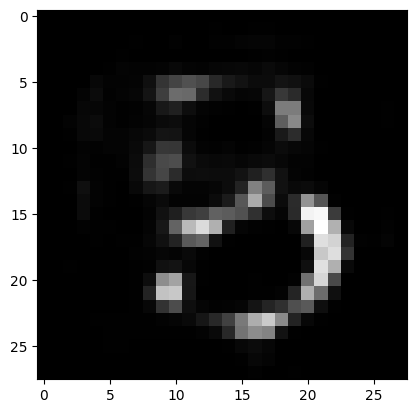

In [102]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

In [11]:
layer_sizes = [784, 1024, 1024, 1024]
encoders, decoders = layerwise_pretraining(X_train_reshaped, layer_sizes, epochs=50)

stacked_ae = K.Sequential()
for encoder in encoders:
    stacked_ae.add(encoder.layers[1])
    
for decoder in decoders[::-1]:
    stacked_ae.add(decoder.layers[1])
    
stacked_ae.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
stacked_ae.summary()

Training layer 1/3
creating ae #0 with input_dim:784, encoding_dim:1024


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 79/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0879

I0000 00:00:1715458270.384831      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715458270.399567      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


369/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0546

W0000 00:00:1715458271.611505      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0542 - val_loss: 0.0214
Epoch 2/50
 54/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209

W0000 00:00:1715458271.955456      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193 - val_loss: 0.0165
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0136
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0134
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0133
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 13/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,200 (8.01 MB)

 Trainable params: 2,099,200 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2264 - val_loss: 0.1591
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1568 - val_loss: 0.1506
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1498 - val_loss: 0.1477
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1476 - val_loss: 0.1462
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1456 - val_loss: 0.1455
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1448 - val_loss: 0.1450
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1440 - val_loss: 0.1446
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1430 - val_loss: 0.1443
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1431 - val_loss: 0.1442
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1429 - val_loss: 0.1440
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1426 - val_loss: 0.1439
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,200 (8.01 MB)

 Trainable params: 2,099,200 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1190 - val_loss: 1.0933
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0964 - val_loss: 1.0933
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0956 - val_loss: 1.0933
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0973 - val_loss: 1.0933
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0956 - val_loss: 1.0933
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0976 - val_loss: 1.0933
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,805,840 (22.15 MB)

 Trainable params: 5,805,840 (22.15 MB)

 Non-trainable params: 0 (0.00 B)

121/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715458318.893729      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1715458319.540681      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


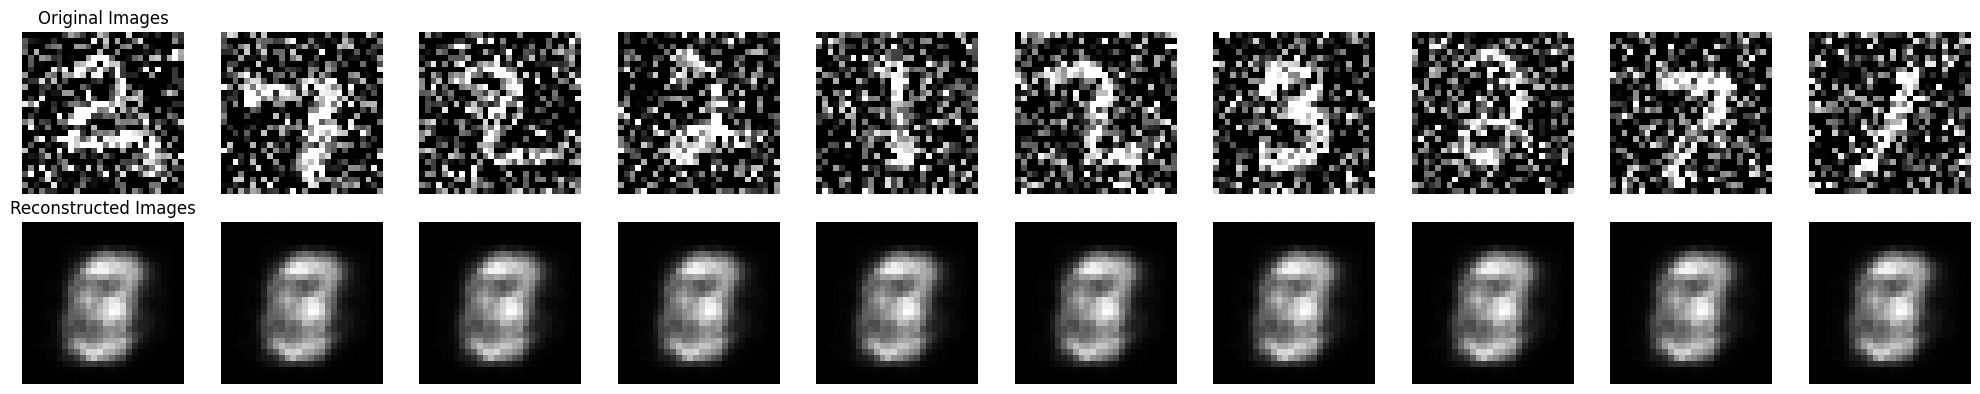

In [12]:
noised_data = noising_process(X_test_reshaped, 0.5)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [13]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

stacked_ae.fit(
    noising_process(X_train_reshaped, 0.5),
    X_train_reshaped,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
 31/375 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0729

W0000 00:00:1715458345.860885      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


368/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0679

W0000 00:00:1715458347.890399      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0679 - val_loss: 0.0639
Epoch 2/50
 29/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0647

W0000 00:00:1715458348.253504      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0644 - val_loss: 0.0618
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0603 - val_loss: 0.0476
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0432 - val_loss: 0.0316
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0274 - val_loss: 0.0204
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0140 - val_loss: 0.0157
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0103 - val_loss: 0.0147
Epoch 13/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


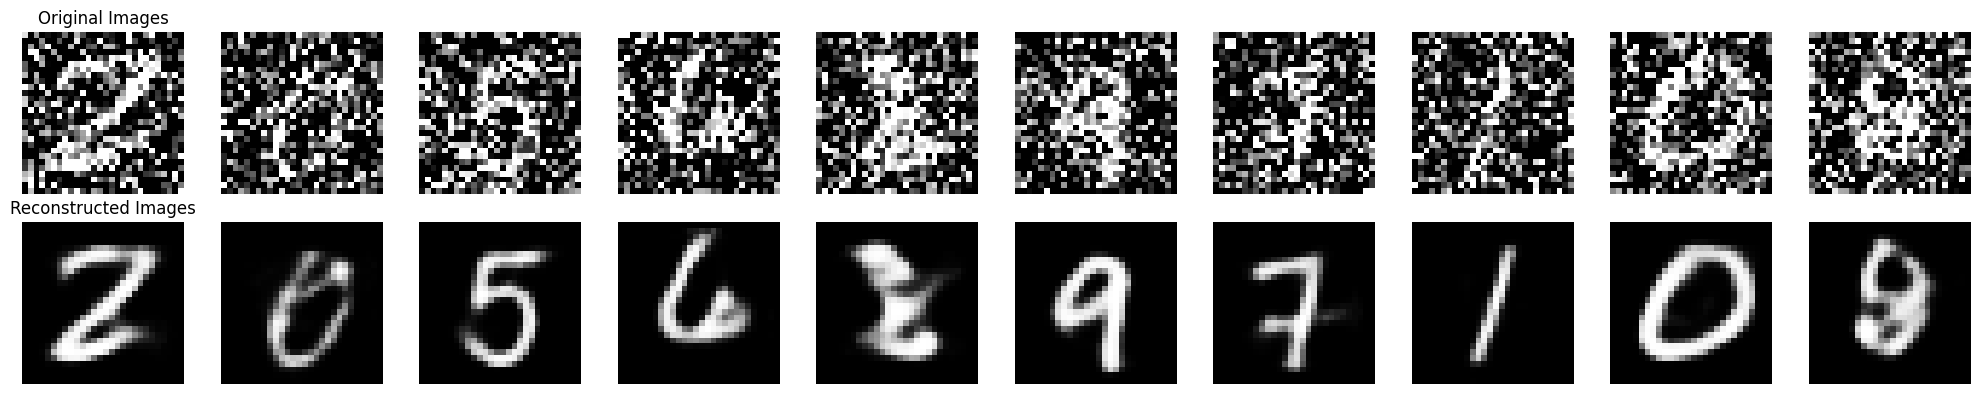

In [14]:
noised_data = noising_process(X_test_reshaped, 0.7)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [15]:
max_iter = 20000
epsilon = 1e-16
previous_loss = None

noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, 784).astype(np.float32), (1, 784)), trainable=True)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = stacked_ae(noised_image)
        loss = -tf.reduce_sum(tf.square(reconstruction - noised_image))     # to maximize similarity through MSE

    gradient = g.gradient(loss, noised_image)

    noised_image.assign_add(gradient * 0.01)

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter-1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = loss.numpy()


iteration: 0, loss: -744.690673828125
iteration: 1000, loss: -0.020237253978848457
iteration: 2000, loss: -0.004976232536137104
iteration: 3000, loss: -0.004319213796406984
iteration: 4000, loss: -0.004247487988322973
iteration: 5000, loss: -0.004203987307846546
Converged at iteration 5824 w/ loss: -0.004188680090010166 and epsilon: 0.0


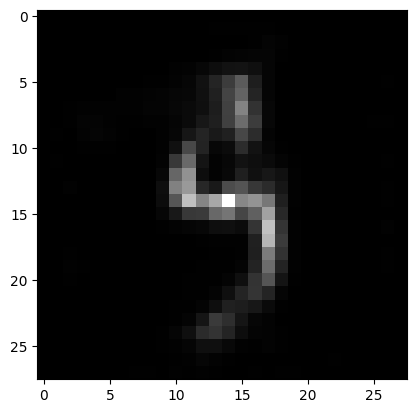

In [16]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

In [19]:
max_iter = 20000
epsilon = 1e-16
previous_loss = None

# Initialize the noised image as a trainable variable
noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, 784).astype(np.float32), (1, 784)), trainable=True)

# Initialize the Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = stacked_ae(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))  # to maximize similarity through MSE

    # Compute gradients and apply them through the optimizer
    gradients = g.gradient(loss, [noised_image])
    optimizer.apply_gradients(zip(gradients, [noised_image]))

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter - 1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = current_loss

iteration: 0, loss: 746.8424072265625
iteration: 1000, loss: 0.07125301659107208
Converged at iteration 1520 w/ loss: 0.06346659362316132 and epsilon: 0.0


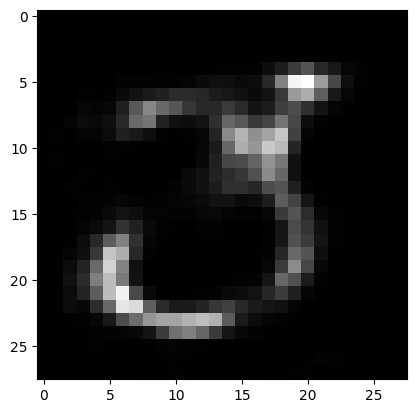

In [20]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

## Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [58]:
conv_inputs = K.Input(shape=((28, 28, 1)))
x_conv = K.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_inputs)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)
x_conv = K.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)

x_conv = K.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x_conv)
conv_outputs = K.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x_conv)

conv_model = K.Model(inputs=conv_inputs, outputs=conv_outputs)

conv_model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 14, 14, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,449 (1.13 MB)

 Trainable params: 296,449 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
conv_model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [60]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.1611 - val_loss: 0.0684
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0682 - val_loss: 0.0663
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0664 - val_loss: 0.0654
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0655 - val_loss: 0.0655
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0650 - val_loss: 0.0640
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0644 - val_loss: 0.0638
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0641 - val_loss: 0.0635
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0638 - val_loss: 0.0635
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0635 - val_loss: 0.0631
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0634 - val_loss: 0.0634
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0632 - val_loss: 0.0629
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


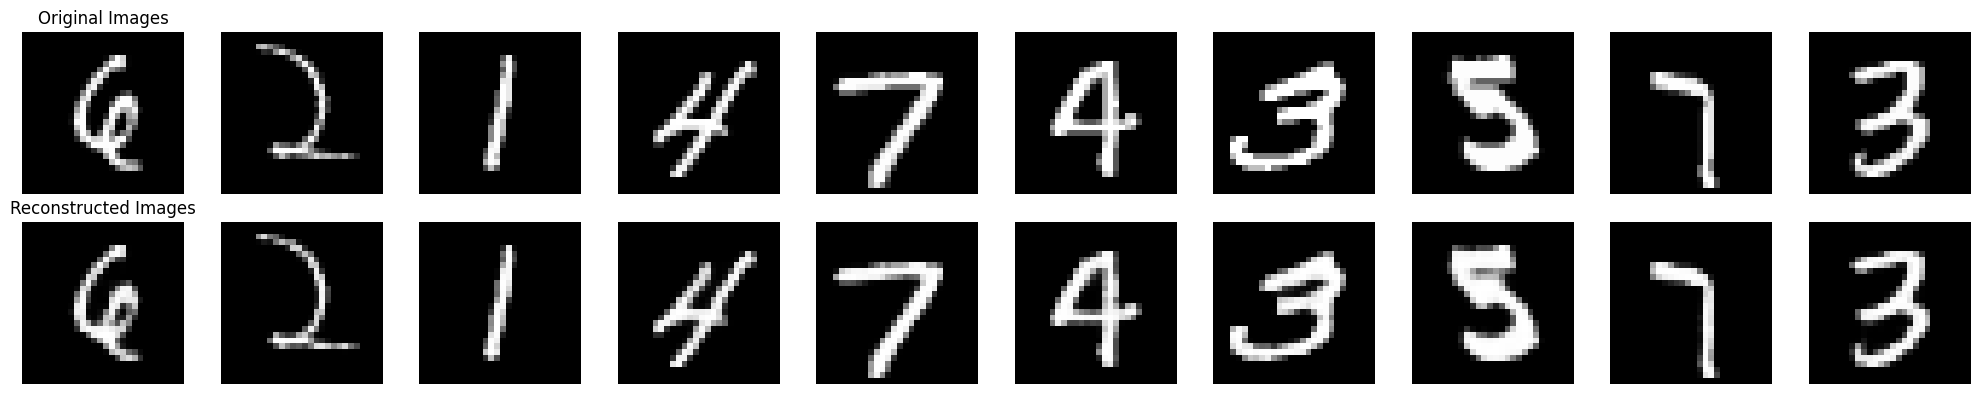

In [61]:
predictions = conv_model.predict(X_test)
print_imgs(X_test, predictions)

In [62]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1414 - val_loss: 0.1101
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1102 - val_loss: 0.1074
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1076 - val_loss: 0.1055
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1062 - val_loss: 0.1044
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1051 - val_loss: 0.1039
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1044 - val_loss: 0.1032
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1038 - val_loss: 0.1029
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1033 - val_loss: 0.1025
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1029 - val_loss: 0.1022
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1025 - val_loss: 0.1018
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1023 - val_loss: 0.1016
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 

The model is able to reconstruct the images even when using some intensive noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


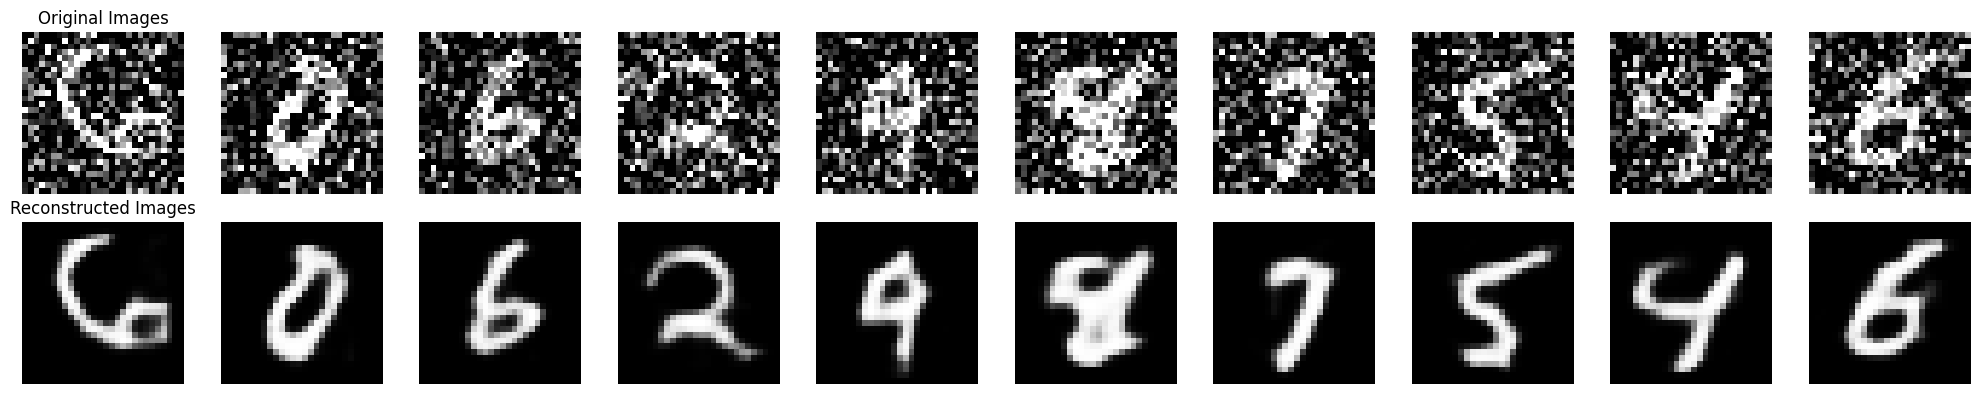

In [63]:
noised_data = noising_process(X_test, 0.5)

predictions = conv_model.predict(noised_data)
print_imgs(noised_data, predictions)

In [64]:
max_iter = 5000
epsilon = 1e-16
previous_loss = None

# Initialize the noised image as a trainable variable
noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28, 1)), trainable=True)

# Initialize the Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for iteration in range(max_iter):

    with tf.GradientTape() as g:
        g.watch(noised_image)
        reconstruction = conv_model(noised_image)
        loss = tf.reduce_sum(tf.square(reconstruction - noised_image))  # to maximize similarity through MSE

    # Compute gradients and apply them through the optimizer
    gradients = g.gradient(loss, [noised_image])
    optimizer.apply_gradients(zip(gradients, [noised_image]))

    current_loss = loss.numpy()

    if iteration % 1000 == 0:
        print(f'iteration: {iteration}, loss: {current_loss}')

    if iteration == max_iter - 1:
        print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

    if previous_loss is not None and abs(previous_loss - current_loss) < epsilon:
        print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
        break

    previous_loss = current_loss

iteration: 0, loss: 886.121337890625
iteration: 1000, loss: 0.0013827614020556211
iteration: 2000, loss: 2.710416424633877e-08
Converged at iteration 2162 w/ loss: 5.2079715729845197e-14 and epsilon: -6.461167321655803e-18


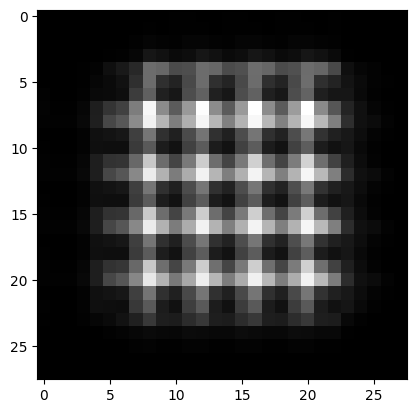

In [65]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()